In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</i>''')

# Evolution of EROIs Until 2050 — code

## _by Adrien Fabre_

## 1. Introduction

This file contains the output of my working paper [Evolution of EROIs Until 2050](http://bit.ly/futureEROIs), it provides only the main results. 

For non technical readers, there is a [pedagogical version](http://bit.ly/future_eroi) of the notebook, which explains the paper in a simplified way.

The code uses the library [pymrio](https://pymrio.readthedocs.io/en/latest/intro.html), which I highly recommend to those who intend to work with Multi-Regional Input-Output data in Python. Pymrio was originally created by [Konstantin Stadler](http://github.com/konstantinstadler/pymrio). 
All the code called in this notebook is open, and comes from [my fork](https://github.com/bixiou/pymrio) (i.e. version) of pymrio.

## 2. The EROI of a Technology Is Not Intrinsic

### 2.1. A Simple Model With A Unique Energy Technology

The coefficient $a_{i,j}$ of technology matrix A represents the quantity of input $i$ required to produce one unit of output $j$.

$$\overset{A=\left(a_{\text{in, out}}\right)=\begin{pmatrix}a_{1,1} & \cdots & a_{1,n}\\
\vdots & \ddots & \vdots\\
a_{n,1} & \ldots & a_{n,n}
\end{pmatrix}\leftarrow\text{ inputs}}{\underset{\text{outputs}}{\downarrow}}$$

Below is an illustrative technology matrix with three inputs (and the same three outputs): an energy technology, materials, and energy. Let $m_e$ be the quantity of materials required to produce one unit of energy.

$$A=\begin{pmatrix}0 & 0 & 1\\
m_{e} & m_{m} & 0\\
E_{e} & E_{m} & 0
\end{pmatrix}\begin{array}{c}
\text{energy technology}\\
\text{materials}\\
\text{energy}
\end{array}$$

One can check that $m_e$ corresponds to the definition above, and one can find the meaning of other coefficients.

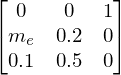

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 'last' 'none' ...
import sympy as sym
from pylab import *
sym.init_printing()
import matplotlib.pyplot as plt

m_e, e_e, m_m, e_m = sym.symbols('m_e e_e m_m e_m') # i_j: units of i required for 1 unit of j
unit_energy_output = sym.Matrix([0, 0, 1])
unit_tech_output = sym.Matrix([1, 0, 0])
# A = sym.Matrix([[0, 0, 1], [m_e, m_m, 0], [e_e, e_m, 0]]) # energy technology, material, energy
A = sym.Matrix([[0, 0, 1], [m_e, 0.2, 0], [0.1, 0.5, 0]]) # energy technology, material, energy
A

Now, we can compute the system-wide EROI of the economy represented by the technology matrix above.

The system-wide **EROI, or Energy Returned On Invested, is the ratio between the energy delivered by the system, and the energy required to build, operate, maintain and dismantle it.** In other words, it is the inverse of the amount of energy required to produce one unit of energy, when the series of all embodied inputs are taken into account.

In [45]:
HTML('''After some algebra (<a href="javascript:code_toggle()">toggle code</a> below to see it), we find the formula for the EROI:''')

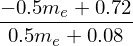

In [22]:
L = sym.eye(3)-A
Linv = L.inv()
EROI = sym.simplify(1/unit_energy_output.transpose().dot((Linv-sym.eye(3)).dot(unit_energy_output)))
EROI

Unsurprisingly, one can see in the Figure below that the EROI decreases with the material intensity of the energy technology, because extracting and processing material requires energy.

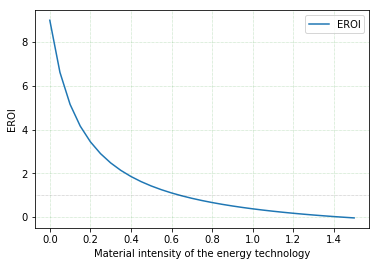

In [23]:
x = np.array(range(31))/20
fig, ax = subplots()

ax.plot(x, [EROI.subs(m_e, M) for M in x], label="EROI")
ax.set_xlabel('Material intensity of the energy technology')
ax.set_ylabel('EROI')
# ax.set_title('EROIs for different energy mixes')
ax.legend(loc=1)
ax.grid(color='g', alpha=0.5, linestyle='dotted', linewidth=0.5)
ax.axhline(y=1, color='black', alpha=0.5, linestyle='dotted', linewidth=0.5)
fig.savefig('EROIs for different material intensity 2.png', dpi=200, bbox_inches="tight")

For an intensity above 0.6, it is below 1. **An EROI below 1 means that the energy technology is not worth developing, because it consumes energy rather than providing it. Such a system is not sustainable** (and not realistic): for it to happen the society should have accumulated energy in the past from an energy source no more accessible, and would waste this energy in that absurd technology.

### 2.2. A Simple Model With A Mix of Two Technologies

Now, let us consider two energy technologies, with the same energy intensity, but different materials intensities.

Even if this example is purely illustrative, let us call them PV (for solar photovoltaic) and gas (for gas power-plant electricity). The numbers are completely made up, but they respect the fact that PV is more material intensive than gas. Here is our new technology matrix, where inputs (and outputs) are (in that order): PV, gas, materials, energy.

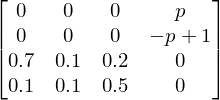

In [24]:
p = sym.symbols('p') # proportion of PV in energy mix
# m_pv (resp. m_oil) units of materials required for 1 kWh from PV (resp. oil)
m_pv, m_oil = 0.7, 0.1 # 
m_pv, m_oil, m_e, e_pv, e_oil, e_e = sym.symbols('m_pv m_oil m_e e_pv e_oil e_e') 
unit_energy_output = sym.Matrix([0, 0, 0, 1])
energy_mix = [p, 1-p] # proportion of [PV, oil]
A = sym.Matrix([[0, 0, 0, p], [0, 0, 0, 1-p], [0.7, 0.1, 0.2, 0], [0.1, 0.1, 0.5, 0]]) # order of ligns/columns: PV, oil, materials, energy
# A = sym.Matrix([[0, 0, 0, pv], [0, 0, 0, 1-pv], [m_pv, m_oil, m_e, 0], [e_pv, e_oil, e_e, 0]]) # order of ligns/columns: PV, oil, materials, energy
A

As you might have guessed, _p_ represents the share of PV in the energy (or electricity) mix.

Using simple algebra, one obtains the formula for the EROI:

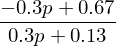

In [25]:
L = sym.eye(4)-A # sym.Matrix(3,3,[1, -m, -1, 0, 0.8, -1, -e, 0, 1])
Linv = L.inv()
EROI2 = sym.simplify(1/unit_energy_output.transpose().dot((Linv-sym.eye(4)).dot(unit_energy_output)))
EROI2

This corresponds to the system-wide EROI. But now that we have two technologies, we can compute the EROI of each of them.

The EROI of a technology is the ratio between the energy delivered by one unit of this technology (over its lifetime), and the energy required to build, operate, maintain and dismantle it.

In our example, the EROIs of PV and gas are, in that order:

In [26]:
EROIpv = sym.simplify(1/unit_energy_output.transpose().dot((Linv-sym.eye(4)).dot(sym.Matrix([1, 0, 0, 0]))))
EROIoil = sym.simplify(1/unit_energy_output.transpose().dot((Linv-sym.eye(4)).dot(sym.Matrix([0, 1, 0, 0]))))

EROIpv
EROIoil

Notice that they depend on the energy mix: **the EROI of a technology is not an intrinsic property**.

Indeed, **it depends on the whole economic system**, or more precisely, of all technologies used in their value chain. (The value chain what I called above the recursive or embodied inputs; its analysis is known as _structural path analysis_ in the literature).

Here, **the higher the share of PV in the mix, the lower the EROI of both technologies**: this comes from the higher material intensity of PV.

Put graphically:

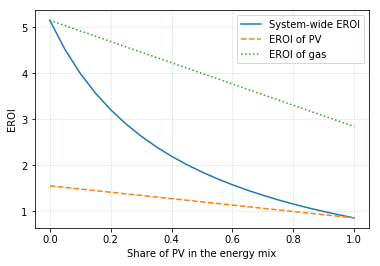

In [27]:
x = np.array(range(21))/20
fig, ax = subplots()

ax.plot(x, [EROI2.subs(p, PV) for PV in x], label="System-wide EROI")
ax.plot(x, [EROIpv.subs(p, PV) for PV in x], label="EROI of PV", linestyle='dashed') # , linestyle='dashed'
ax.plot(x, [EROIoil.subs(p, PV) for PV in x], label="EROI of gas", linestyle='dotted') # , linestyle='dotted'
ax.set_xlabel('Share of PV in the energy mix')
ax.set_ylabel('EROI')
# ax.set_title('EROIs for different energy mixes')
ax.legend(loc=1)
ax.grid(color='g', alpha=0.5, linestyle='dotted', linewidth=0.5)
fig.savefig('EROIs for different energy mixes - gas 2.png', dpi=200, bbox_inches="tight")

One can see that for highest penetration of PV, the EROI falls below unity. In other words, a renewable energy mix with 100% PV is not sustainable in this example. 

Even more worrying, if one computes the EROI of PV in an energy mix relying mostly on gas, one would find a high-enough EROI for PV (meaning, above 1).

Hence, one cannot conclude that a technology is sufficiently efficient (or sustainable) just by computing its EROI in the current energy mix.

Yet, EROIs computations are _always_ done from actual data of our economy, and could falsely represent the efficiencies of energy technologies in another energy mix, say, a 100% renewable one.

In the next sections, I'll go into the data and compute for the first time EROIs of different electricity technologies under an energy transition towards renewables.

## 3. Estimation of Current and Future EROIs

### 3.1 Setting and Data

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
# One needs to install my fork of pymrio, available at https://github.com/bixiou/pymrio
#   To do this, clone my repository from github, go on the console on the pymrio folder, and
#   type 'python3 setup.py sdist', then 'python3 setup.py install'
import pymrio
from pymrio.core.mriosystem import IOSystem as IOS
from pymrio.tools.iomath import div0
from pymrio.tools.iofunctions import *
import pandas as pd
import numpy as np
# import scipy.io
import scipy.sparse as sp 
from scipy.sparse import linalg as spla
import operator
import warnings
import matplotlib.pyplot as plt
from pylab import *
import pickle
from openpyxl import load_workbook
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 'last' 'none' ...
warnings.filterwarnings('ignore')

In [2]:
%%capture
# Unfortunately, the database THEMIS is not open (you can ask to NTNU or thomas.gibon@list.lu) if they can provide it to you
path_themis = '/media/adrien/dd/adrien/DD/Économie/Données/Themis/'
path_io = '/media/adrien/dd/adrien/DD/Économie/Données/'
# path_io = '/media/sf_U_DRIVE/Données/'
years = [2010, 2030, 2050]
scenarios = ['BL', 'BM']
scenarios_dlr = ['REF', 'ER', 'ADV'] 
# themis, EROIs_mixes, dlr, EROIs_Mixes = pickle.load(open(path_io+'Themis/EROIs.pkl', 'rb'))
# EROIs_mixes, dlr, EROIs_Mixes = pickle.load(open(path_io+'Themis/EROIs.pkl', 'rb'))

In [3]:
# themis = pymrio.themis_parser(path_themis)
# # Following lines computes all results, lasts ~3h
themis = pymrio.themis_parser(path_themis, dlr_files = True, compute_all = True)
for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']: 
    for y in [2010, 2030, 2050]: _ = themis[s][y].erois_and_prices(recompute = True)
erois_prices = pd.concat([themis[s][y].eroi_price for y in [2010, 2030, 2050] for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']], \
                         keys=[(s,y) for y in [2010, 2030, 2050] for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']], names=['scenario', 'year'])

In [4]:
themis = pickle.load(open(path_io+'Themis/themis.pkl', 'rb'))
erois_prices = pickle.load(open(path_io+'Themis/erois_prices.pkl', 'rb'))
# erois_prices_wo_GW = pickle.load(open(path_io+'Themis/erois_prices_wo_GW.pkl', 'rb'))

In [4]:
pickle.dump(themis, open(path_io + 'Themis/themis.pkl', 'wb'))
export_all_excel(path_io+'Themis/', themis)
# for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']:
#     pickle.dump(themis[s], open(path_io + 'Themis/themis_'+s+'.pkl', 'wb'))
pickle.dump(erois_prices, open(path_io + 'Themis/erois_prices.pkl', 'wb'))
# pickle.dump(erois_prices_wo_GW, open(path_io + 'Themis/erois_prices_wo_GW.pkl', 'wb'))

To compute EROIs, I use input-output tables (i.e. technology matrices) representing the global economy. 

The original database is [Exiobase](https://www.exiobase.eu/), and the model I used is [THEMIS](https://sci-hub.tw/https%3A//pubs.acs.org/doi/abs/10.1021/acs.est.5b01558), which is precisely what we need: input-output tables (IOT) of 2010, and prospective IOT for 2030 and 2050, under two [scenarios](http://gen.lib.rus.ec/book/index.php?md5=4D5AF94A02A48B799CF77641509C1C6B) of the International Energy Agency: BaseLine (with a high share of fossils) and Blue Map (with a high share of renewables).

Footnote 7 affirms that neglecting to subtract from _fuel input_  secondary fuels used by thermal plants in non final steps is a good approximation, in the sense that the variation of _fuel input_ it implies is below 0.1% for all technologies. Here is the proof of this statement for scenario BL and year 2010.

### 3.2 Main Results

In [35]:
results(themis, longnames=True)

scenario      Baseline ('BL')                                   \
year                     2010         2030         2050          
stat                     EROI    mix  EROI    mix  EROI    mix   
biomass w CCS               –   0.00     –   0.00     –   0.00   
biomass&Waste            11.4   0.01   6.3   0.02   5.9   0.03   
ocean                     5.5   0.00   2.4   0.00   2.9   0.00   
geothermal                5.4   0.00   5.2   0.01   5.1   0.01   
solar CSP                21.6   0.00   8.9   0.00   9.1   0.01   
solar PV                  9.3   0.00   7.4   0.01   7.2   0.01   
wind offshore             9.4   0.00  11.0   0.01  10.5   0.01   
wind onshore              9.5   0.01   9.3   0.04   8.1   0.04   
hydro                    13.2   0.16  11.9   0.14  11.9   0.12   
nuclear                  10.5   0.14   7.3   0.11   7.0   0.10   
gas w CCS                   –   0.00     –   0.00   7.5   0.00   
coal w CCS                  –   0.00     –   0.00   6.2   0.00   
oil                       8.4   0.06   9.8   0.02   9.9   0.01   
gas                      13.9   0.21  15.0   0.21  14.9   0.23   
coal                     12.9   0.42  11.5   0.45  11.5   0.45   
Total (PWh/a)            12.2  19.76  10.9  34.29  10.7  45.97   

scenario      Blue Map ('BM', +2°C)                      \
year                           2030         2050          
stat                           EROI    mix  EROI    mix   
biomass w CCS                   4.6   0.00   4.0   0.01   
biomass&Waste                   5.5   0.06   5.2   0.05   
ocean                           3.7   0.00   5.8   0.00   
geothermal                      5.2   0.01   5.4   0.02   
solar CSP                       8.2   0.02   7.9   0.06   
solar PV                        6.4   0.02   6.0   0.06   
wind offshore                   7.7   0.03   6.3   0.04   
wind onshore                    7.1   0.08   7.3   0.08   
hydro                          12.8   0.18  13.1   0.14   
nuclear                         7.3   0.19   7.4   0.24   
gas w CCS                       7.9   0.01   9.1   0.05   
coal w CCS                      7.1   0.05   7.1   0.12   
oil                             9.5   0.03   7.3   0.01   
gas                            17.3   0.14  19.7   0.11   
coal                           11.6   0.18  12.4   0.01   
Total (PWh/a)                   9.1  28.01   8.0  40.22   

scenario      Advanced ER ('ADV', 100% renewable)                      
year                                         2030         2050         
stat                                         EROI    mix  EROI    mix  
biomass w CCS                                   –   0.00     –   0.00  
biomass&Waste                                 5.2   0.05   4.6   0.05  
ocean                                         4.8   0.01   4.9   0.03  
geothermal                                    3.8   0.03   3.9   0.07  
solar CSP                                     9.3   0.07   7.8   0.22  
solar PV                                      5.4   0.14   4.7   0.21  
wind offshore                                 6.5   0.04   6.4   0.10  
wind onshore                                  7.2   0.17   5.8   0.24  
hydro                                        11.0   0.13  10.9   0.08  
nuclear                                       8.3   0.02     –   0.00  
gas w CCS                                       –   0.00     –   0.00  
coal w CCS                                      –   0.00     –   0.00  
oil                                          10.0   0.01     –   0.00  
gas                                          16.5   0.18     –   0.00  
coal                                         10.4   0.16  11.5   0.00  
Total (PWh/a)                                 8.1  36.74   5.8  64.04

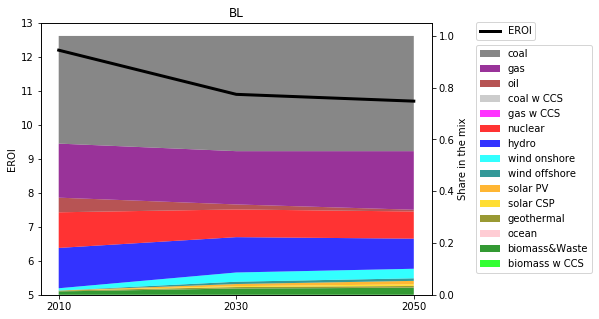

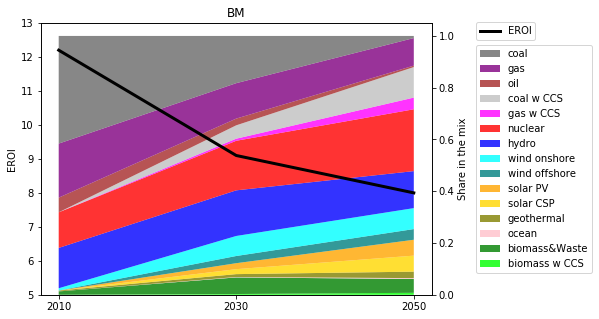

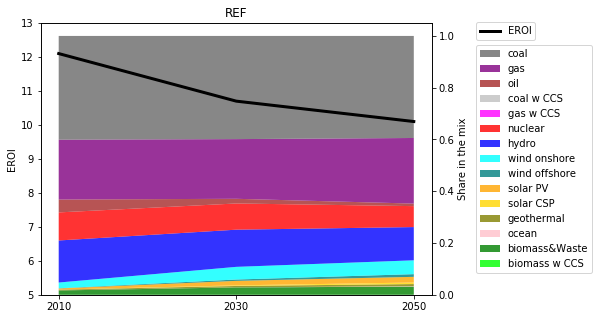

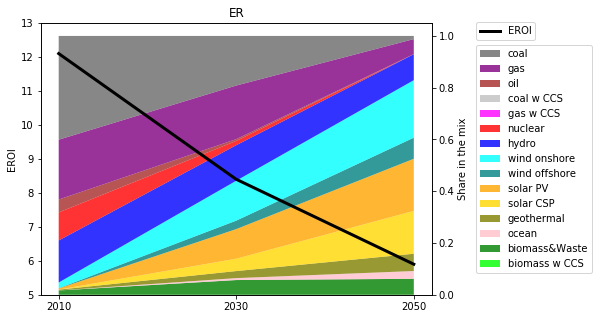

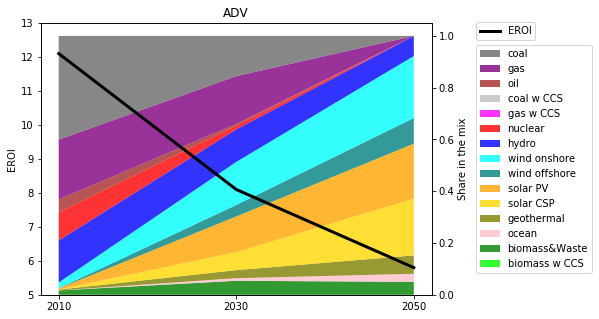

In [70]:
EROIs_mixes = results(themis, scenarios = scenarios+scenarios_dlr, to_plot=True)
for scenario_fig in scenarios+scenarios_dlr:
    if 'total' in EROIs_mixes.index: tot_name = 'total'
    else: tot_name = 'Total (PWh/a)'
    EROIs_mixes = EROIs_mixes.loc[['biomass w CCS', 'biomass&Waste', 'ocean', 'geothermal','solar CSP','solar PV','wind offshore',\
                                   'wind onshore','hydro','nuclear', 'gas w CCS', 'coal w CCS', 'oil', 'gas', 'coal', tot_name]]
    InteractiveShell.ast_node_interactivity = 'last'
    colors = ['lime', 'green', 'pink', 'olive', 'gold', 'orange', 'teal', 'aqua', 'b', 'r', 'magenta', 'silver', 'brown', 'purple', 'dimgrey']
    fig = plt.figure(figsize=(7,5)) # 7,5
    _ = ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(years, EROIs_mixes[[(scenario_fig, year, 'EROI') for year in years]].loc[tot_name], \
            label='EROI', color='black', zorder=20, linewidth=3)
    _ = ax.set_ylabel('EROI')
    _ = ax.set_ylim([5, 13]) # 5, 10; 13, 18; 11.5, 17.5
    # ax.set_zorder(1)
    _ = ax2 = ax.twinx()
    _ = ax2.stackplot(years, EROIs_mixes.replace('–',0).fillna(0)[[(scenario_fig, year, 'mix') for year in years]].iloc[:15], \
                  labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
    _ = ax2.set_title(scenario_fig)
    _ = plt.ylabel('Share in the mix')
    _ = plt.xlabel(scenario_fig+' scenario')
    _ = xticks(years)
    _ = handles, labels = ax2.get_legend_handles_labels()
    _ = ax2.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.1,0.5)) 
    _ = ax.legend(loc='center left', bbox_to_anchor=(1.1,0.97))
    _ = ax.set_zorder(ax2.get_zorder()+1)
    _ = ax.patch.set_visible(False)
    _ = fig.savefig('Evolution of EROI in '+scenario_fig+'.png', dpi=200, bbox_inches="tight")

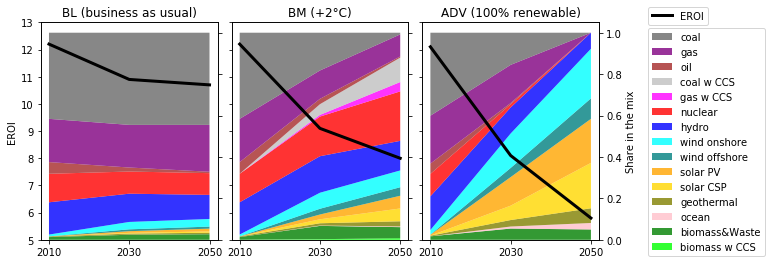

In [38]:
EROIs_mixes = results(themis, scenarios = scenarios+scenarios_dlr, to_plot=True)
# f, axarr = plt.subplots(2, sharex=True)
# axarr[0].plot(x, y)
# axarr[0].set_title('Sharing X axis')
# axarr[1].scatter(x, y)
if 'total' in EROIs_mixes.index: tot_name = 'total'
else: tot_name = 'Total (PWh/a)'
EROIs_mixes = EROIs_mixes.loc[['biomass w CCS', 'biomass&Waste', 'ocean', 'geothermal','solar CSP','solar PV','wind offshore',\
                               'wind onshore','hydro','nuclear', 'gas w CCS', 'coal w CCS', 'oil', 'gas', 'coal', tot_name]]
InteractiveShell.ast_node_interactivity = 'last'
colors = ['lime', 'green', 'pink', 'olive', 'gold', 'orange', 'teal', 'aqua', 'b', 'r', 'magenta', 'silver', 'brown', 'purple', 'dimgrey']
fig = plt.figure(figsize=(10,4)) # 7,5
_ = ylims = [5, 13] # 5, 10; 13, 18

ax1 = fig.add_subplot(1, 3, 1)
_ = ax1.plot(years, EROIs_mixes[[('BL', year, 'EROI') for year in years]].loc[tot_name], \
        label='EROI', color='black', zorder=20, linewidth=3)
_ = ax1.set_ylabel('EROI')
_ = ax1.set_ylim(ylims)
# ax.set_zorder(1)
_ = ax12 = ax1.twinx()
_ = ax12.stackplot(years, EROIs_mixes.fillna(0)[[('BL', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax1.set_title('BL (business as usual)')
_ = xticks(years)
handles, labels = ax12.get_legend_handles_labels()
_ = ax1.set_zorder(ax12.get_zorder()+1)
_ = ax1.patch.set_visible(False)
# ax12.get_yaxis().set_visible(False)
_ = ax12.tick_params(labelright=False)

ax2 = fig.add_subplot(132)
_ = ax2.plot(years, EROIs_mixes[[('BM', year, 'EROI') for year in years]].loc[tot_name], \
        label='EROI', color='black', zorder=20, linewidth=3)
# ax2.set_ylabel('EROI')
_ = ax2.set_ylim(ylims)
# ax.set_zorder(1)
ax22 = ax2.twinx()
_ = ax22.stackplot(years, EROIs_mixes.fillna(0)[[('BM', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax2.set_title('BM (+2°C)')
_ = xticks(years)
handles, labels = ax22.get_legend_handles_labels()
_ = ax2.set_zorder(ax22.get_zorder()+1)
_ = ax2.patch.set_visible(False)
_ = ax2.tick_params(labelleft=False)
_ = ax22.tick_params(labelright=False)
# ax2.get_yaxis().set_visible(False)
# ax22.get_yaxis().set_visible(False)

ax3 = fig.add_subplot(133)
_ = ax3.plot(years, EROIs_mixes[[('ADV', year, 'EROI') for year in years]].loc[tot_name], \
        label='EROI', color='black', zorder=20, linewidth=3)
# ax3.set_ylabel('EROI')
_ = ax3.set_ylim(ylims)
# ax.set_zorder(1)
ax32 = ax3.twinx()
_ = ax32.stackplot(years, EROIs_mixes.replace('–',0).fillna(0)[[('ADV', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax3.set_title('ADV (100% renewable)') # ER (+2°C wo CCS nor nuclear)
_ = plt.ylabel('Share in the mix')
_ = xticks(years)
handles, labels = ax32.get_legend_handles_labels()
_ = ax32.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.25,0.45)) # (1.1,0.5)
_ = ax3.legend(loc='center left', bbox_to_anchor=(1.25,1.03)) # (1.1,0.97)
_ = ax3.set_zorder(ax32.get_zorder()+1)
_ = ax3.patch.set_visible(False)
# ax3.get_yaxis().set_visible(False)
_ = ax3.tick_params(labelleft=False)
_ = plt.subplots_adjust(wspace=0.08, hspace=0.08)

_ = fig.savefig('Evolution of EROIs IEA-ADV.png', dpi=200, bbox_inches="tight")

## 4. Implications of a Decreasing EROI

### 4.1 Regressions price ~ EROI

In [39]:
# N = 2079, Inv regression: p = 18 + 85/EROI (R^2=0.54); log regression: p = 100·EROI^-0.57 (R^2=0.57)

# Preparation
EROI_for_prediction = np.array([i/100 for i in range(1,10000)], ndmin=2, dtype=float).transpose()
inv_EROI_for_prediction = 1/EROI_for_prediction
log_EROI_for_prediction = np.log10(EROI_for_prediction)
erois = np.array(erois_prices['eroi']) # erois_prices_wo_GW yield almost same results
prices = np.array(erois_prices['price']) 
erois_cleaned = erois[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
prices_cleaned = prices[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
EROI_ = np.array(erois_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))], ndmin=2, dtype=float).transpose()
p_ = prices_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))]
EROI = np.array([EROI_[i] for i, x in enumerate(p_) if EROI_[i]>0 and x>0])
p = np.array([x for i, x in enumerate(p_) if EROI_[i]>0 and x>0])

# Inv regression
reg_inv = LinearRegression().fit(1/EROI, p)  # R^2: 0.54 ; p = 18 + 85/EROI
print('R^2 inv:', round(reg_inv.score(1/EROI, p), 2), '; p =', round(reg_inv.intercept_, 2), '+', round(reg_inv.coef_[0], 2), '/ EROI')
p_predicted = reg_inv.predict(inv_EROI_for_prediction)

# log regression
reg_log = LinearRegression().fit(np.log10(EROI), np.log10(p)) # R^2: 0.61; p = 94 + EROI^-0.57
print('R^2 log:', round(reg_log.score(np.log10(EROI), np.log10(p)), 2), '; log p =',round(reg_log.coef_[0], 2),'· log EROI +',round(reg_log.intercept_, 2)) 
log_p_predicted = reg_log.predict(log_EROI_for_prediction)

# Both regression explain same share of variance
TSS = sum((p - np.mean(p))**2)
iSS = sum((p - reg_inv.predict(1/EROI))**2)
lSS = sum((p - 10**reg_log.predict(np.log10(EROI)).flatten())**2)
print('"true" R^2 inv:', round(1-iSS/TSS, 2), '; standard-error: ', round(sum((p - reg_inv.predict(1/EROI))**2)**0.5/p.size, 2), '; N = ', p.size)
print('"true" R^2 log:', round(1-lSS/TSS, 2), '; standard-error: ', round(sum((p - 10**reg_log.predict(np.log10(EROI)).flatten())**2)**0.5/p.size,2))

R^2 inv: 0.55 ; p = 18.16 + 85.11 / EROI
R^2 log: 0.61 ; log p = -0.57 · log EROI + 1.99
"true" R^2 inv: 0.55 ; standard-error:  0.29 ; N =  2079
"true" R^2 log: 0.58 ; standard-error:  0.28


In [13]:
# To have complete regression results
loglog = sm.OLS(np.log10(p), sm.add_constant(np.log10(EROI))).fit()
print(loglog.summary())
inv = sm.OLS(p, sm.add_constant(1/EROI)).fit()
print(inv.summary())

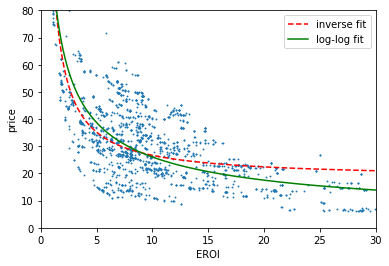

In [40]:
# Both regressions
fig = plt.figure()
ax = plt.subplot(111)
_= plt.scatter(x=EROI, y=p, marker = '.', s = 3)
_= ax.plot(EROI_for_prediction, p_predicted, color='r', linestyle='--', label='inverse fit')
_= ax.plot(EROI_for_prediction, np.power(10, log_p_predicted), color='g', label='log-log fit')
_= ax.set_xlim(0, 30)
_= ax.set_ylim(0, 80)
_= plt.ylabel('price')
_= plt.xlabel('EROI')
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels, loc='upper right')
_ = fig.savefig('regression price ~ EROI.png', dpi=200, bbox_inches="tight")

R^2 inv: 0.54 ; p = 20.58 + 72.11 / EROI
R^2 log: 0.58 ; log p = -0.46 · log EROI + 1.9
"true" R^2 inv: 0.54 ; standard-error:  0.98 ; N =  104
"true" R^2 log: 0.62 ; standard-error:  0.9


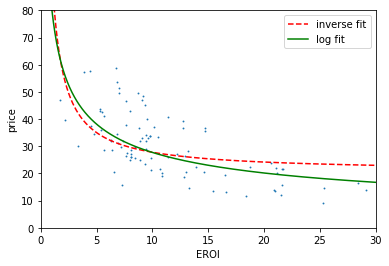

In [41]:
# REGRESSIONS price ~ EROI restricted to BL 2010
# N = 104

# Preparation
EROI_for_prediction = np.array([i/100 for i in range(1,10000)], ndmin=2, dtype=float).transpose()
inv_EROI_for_prediction = 1/EROI_for_prediction
log_EROI_for_prediction = np.log10(EROI_for_prediction)
erois = np.array(erois_prices.loc[('BL', 2010)]['eroi']) # erois_prices_wo_GW yield almost same results
prices = np.array(erois_prices.loc[('BL', 2010)]['price']) 
erois_cleaned = erois[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
prices_cleaned = prices[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
EROI_ = np.array(erois_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))], ndmin=2, dtype=float).transpose()
p_ = prices_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))]
EROI = np.array([EROI_[i] for i, x in enumerate(p_) if EROI_[i]>0 and x>0]) # EROI_[i]>2.5
p = np.array([x for i, x in enumerate(p_) if EROI_[i]>0 and x>0])

# Inv regression
reg_inv = LinearRegression().fit(1/EROI, p)
print('R^2 inv:', round(reg_inv.score(1/EROI, p), 2), '; p =', round(reg_inv.intercept_, 2), '+', round(reg_inv.coef_[0], 2), '/ EROI')
p_predicted = reg_inv.predict(inv_EROI_for_prediction)

# log regression
reg_log = LinearRegression().fit(np.log10(EROI), np.log10(p))
print('R^2 log:', round(reg_log.score(np.log10(EROI), np.log10(p)), 2), '; log p =',round(reg_log.coef_[0], 2),'· log EROI +',round(reg_log.intercept_, 2)) 
log_p_predicted = reg_log.predict(log_EROI_for_prediction)

# Both regression explain same share of variance
TSS = sum((p - np.mean(p))**2)
iSS = sum((p - reg_inv.predict(1/EROI))**2)
lSS = sum((p - 10**reg_log.predict(np.log10(EROI)).flatten())**2)
print('"true" R^2 inv:', round(1-iSS/TSS, 2), '; standard-error: ', round(sum((p - reg_inv.predict(1/EROI))**2)**0.5/p.size, 2), '; N = ', p.size)
print('"true" R^2 log:', round(1-lSS/TSS, 2), '; standard-error: ', round(sum((p - 10**reg_log.predict(np.log10(EROI)).flatten())**2)**0.5/p.size,2))

# Both regressions
fig = plt.figure()
ax = plt.subplot(111)
_= plt.scatter(x=EROI, y=p, marker = '.', s = 3)
_= ax.plot(EROI_for_prediction, p_predicted, color='r', linestyle='--', label='inverse fit')
_= ax.plot(EROI_for_prediction, np.power(10, log_p_predicted), color='g', label='log fit')
_= ax.set_xlim(0, 30)
_= ax.set_ylim(0, 80)
_= plt.ylabel('price')
_= plt.xlabel('EROI')
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels, loc='upper right')
_ = fig.savefig('regression price ~ EROI BL2010.png', dpi=200, bbox_inches="tight")

In [66]:
# To have complete regression results
loglog = sm.OLS(np.log10(p), sm.add_constant(np.log10(EROI))).fit()
print(loglog.summary())
inv = sm.OLS(p, sm.add_constant(1/EROI)).fit()
print(inv.summary())

### 4.2 Predicted average global price of electricity (in €/MWh)

In [63]:
print('BL 2010', round(themis['BL'][2010].eroi_price['price'][('World', 'total')]))
for y in [2030, 2050]: 
    for s in ['BL', 'BM', 'ADV']: print(s, y, round(themis[s][y].eroi_price['price'][('World', 'total')]))

BL 2010 27.0
BL 2030 28.0
BM 2030 30.0
ADV 2030 30.0
BL 2050 28.0
BM 2050 30.0
ADV 2050 32.0


## 5. Contact

**Adrien Fabre**, 2018  
[personal website](https://sites.google.com/view/adrien-fabre)  
adrien.fabre@psemail.eu

## References

### Theory
* Input-Output Analysis: [wikipedia](https://en.wikipedia.org/wiki/Input%E2%80%93output_model), [Miller & Blair (2009)](http://gen.lib.rus.ec/book/index.php?md5=8803A190575D7587AA8112F76BB82070), [Eurostat](http://ec.europa.eu/eurostat/documents/3859598/5902113/KS-RA-07-013-EN.PDF/b0b3d71e-3930-4442-94be-70b36cea9b39?version=1.0)
* EROI: [King et al. (2010)](http://careyking.com/wp-content/uploads/2013/10/ASME-ES90414_EROIMethodology-Wind_2010_King.pdf), [Murhpy et al. (2011)](http://science-and-energy.org/wp-content/uploads/2016/03/Murphy-et-al-2011-Order-from-Chaos-EROI-Protocol.pdf)
* EROI is not intrinsic: [King (2014)](https://sci-hub.tw/https%3A//doi.org/10.1016/j.energy.2014.05.032)

### Estimations of EROI
* [Dale (2010)](https://ir.canterbury.ac.nz/bitstream/handle/10092/5156/Dale2011GlobalEnergyModelling-ABiophysicalApproach.pdf)
* [Weißbach et al. (2013)](https://sci-hub.tw/https%3A//www.sciencedirect.com/science/article/pii/S0360544213000492)
* [Hall et al. (2014)](https://sci-hub.tw/https%3A//www.sciencedirect.com/science/article/pii/S0301421513003856)

### Link between EROI and affluence
> Think of a society dependent upon one resource: its domestic oil. If the EROI for this oil was 1.1:1 then one could pump the oil out of the ground and look at it. If it were 1.2:1 you could also refine it and look at it, 1.3:1 also distribute it to where you want to use it but all you could do is look at it. Hall et al. 2008 examined the EROI required to actually run a truck and found that if the energy included was enough to build and maintain the truck and the roads and bridges required to use it (i.e., depreciation), one would need at least a 3:1. Now if you wanted to put something in the truck, say some grain, and deliver it that would require an EROI of, say, 5:1 to grow the grain. If you wanted to include depreciation on the oil field worker, the refinery worker, the truck driver and the farmer you would need an EROI of say 7 or 8:1 to support the families. If the children were to be educated you would need perhaps 9 or 10:1, have health care 12:1, have arts in their life maybe 14:1 and so on. [Hall (2011)](http://pakacademicsearch.com/pdf-files/agr/740/1773-1777%20Volume%203,%20Issue%2010%20(October%202011%29.pdf)

* [Hall (2011)](http://pakacademicsearch.com/pdf-files/agr/740/1773-1777%20Volume%203,%20Issue%2010%20(October%202011%29.pdf)
* [Hall et al. (2009)](http://dieoff.com/_Energy/WhatIsTheMinumEROI_energies-02-00025.pdf)
* [Lambert & Lambert (2011)](https://mahb.stanford.edu/wp-content/uploads/2014/03/sustainability_LambertLambert_2011.pdf)
* [Lambert et al. (2014)](https://www.sciencedirect.com/science/article/pii/S0301421513006447)
* [Fizaine & Court (2016)](https://sci-hub.tw/https%3A//www.sciencedirect.com/science/article/pii/S0301421516302087)

### Data
* [Exiobase](https://www.exiobase.eu/)
* [THEMIS](https://sci-hub.tw/https%3A//pubs.acs.org/doi/abs/10.1021/acs.est.5b01558) Thank you a lot Thomas Gibon for providing me the code and helping me!
* [IEA scenarios](http://gen.lib.rus.ec/book/index.php?md5=4D5AF94A02A48B799CF77641509C1C6B)
* [Energy [R]evolution](https://www.greenpeace.org/archive-international/Global/international/publications/climate/2015/Energy-Revolution-2015-Full.pdf) (commanded and funded by Greenpeace, realised by a team of the DLR using their model [REMix](https://www.dlr.de/tt/en/desktopdefault.aspx/tabid-2885/4422_read-12423/))
* [Cecilia 2050](https://cecilia2050.eu/publications/168)

## Appendix

### A. Updating a Matrix A To a New Given Mix

See the function `change_mix` in [the code](https://github.com/bixiou/pymrio/blob/master/pymrio/tools/iofunctions.py).

### B. Example of Non-Decreasing Relation Between EROI and Price

See [this page](https://www.desmos.com/calculator/ne4oqunhsm) for the computations.

### C. Complete Results

EROIs and mix for Greenpeace scenarios:

In [43]:
results(themis, scenarios=['REF', 'ER', 'ADV'], longnames=True)

scenario      Reference DLR ('REF')                                   \
year                           2010         2030         2050          
stat                           EROI    mix  EROI    mix  EROI    mix   
biomass w CCS                     –   0.00     –   0.00     –   0.00   
biomass&Waste                   8.5   0.02   6.4   0.03   5.0   0.03   
ocean                           4.7   0.00   2.0   0.00   2.5   0.00   
geothermal                      5.6   0.00   3.8   0.01   2.5   0.01   
solar CSP                      35.5   0.00   9.3   0.00   8.0   0.01   
solar PV                       13.7   0.00   7.0   0.02   5.3   0.02   
wind offshore                   9.1   0.00   8.6   0.01   7.8   0.01   
wind onshore                    9.7   0.02   9.1   0.05   7.2   0.05   
hydro                          12.2   0.16  11.4   0.14  11.2   0.13   
nuclear                        12.2   0.11   7.3   0.10   7.1   0.08   
gas w CCS                         –   0.00     –   0.00     –   0.00   
coal w CCS                        –   0.00     –   0.00     –   0.00   
oil                             8.4   0.05  11.1   0.02  11.4   0.01   
gas                            14.9   0.23  15.3   0.23  15.6   0.25   
coal                           11.8   0.40  11.3   0.40  11.3   0.39   
Total (PWh/a)                  12.1  22.60  10.7  36.26  10.1  50.11   

scenario      Energy [R]evolution ('ER', +2°C, no CCS nor nuclear)         \
year                                                          2030          
stat                                                          EROI    mix   
biomass w CCS                                                  –     0.00   
biomass&Waste                                                5.3     0.06   
ocean                                                        4.3     0.01   
geothermal                                                   3.6     0.03   
solar CSP                                                    8.5     0.05   
solar PV                                                     5.6     0.11   
wind offshore                                                5.6     0.03   
wind onshore                                                 7.2     0.15   
hydro                                                       11.0     0.14   
nuclear                                                      8.3     0.02   
gas w CCS                                                      –     0.00   
coal w CCS                                                     –     0.00   
oil                                                         10.0     0.01   
gas                                                         16.6     0.21   
coal                                                        10.7     0.19   
Total (PWh/a)                                                8.4    33.60   

scenario                   Advanced ER ('ADV', 100% renewable)               \
year           2050                                       2030         2050   
stat           EROI    mix                                EROI    mix  EROI   
biomass w CCS     –   0.00                                   –   0.00     –   
biomass&Waste   4.7   0.06                                 5.2   0.05   4.6   
ocean           4.5   0.03                                 4.8   0.01   4.9   
geothermal      3.7   0.07                                 3.8   0.03   3.9   
solar CSP       7.7   0.17                                 9.3   0.07   7.8   
solar PV        4.4   0.20                                 5.4   0.14   4.7   
wind offshore   5.9   0.08                                 6.5   0.04   6.4   
wind onshore    6.0   0.22                                 7.2   0.17   5.8   
hydro          11.1   0.10                                11.0   0.13  10.9   
nuclear           –   0.00                                 8.3   0.02     –   
gas w CCS         –   0.00                                   –   0.00     –   
coal w CCS        –   0.00                                   

Quality-adjusted EROIs and mix for THEMIS/IEA scenarios:

In [46]:
results(themis, stats=['eroi_adj', 'mix'], scenarios=['BL', 'BM'], longnames=True)

scenario      Baseline ('BL')                                         \
year                     2010            2030            2050          
stat                 EROI adj    mix EROI adj    mix EROI adj    mix   
biomass w CCS               –   0.00        –   0.00        –   0.00   
biomass&Waste            20.8   0.01     12.6   0.02     11.7   0.03   
ocean                     9.1   0.00      4.4   0.00      5.5   0.00   
geothermal               11.5   0.00     10.3   0.01     10.2   0.01   
solar CSP                44.6   0.00     17.7   0.00     18.2   0.01   
solar PV                 17.5   0.00     14.8   0.01     14.5   0.01   
wind offshore            19.6   0.00     21.2   0.01     20.5   0.01   
wind onshore             18.4   0.01     18.1   0.04     15.8   0.04   
hydro                    25.6   0.16     23.0   0.14     23.0   0.12   
nuclear                  19.2   0.14     13.4   0.11     13.0   0.10   
gas w CCS                   –   0.00        –   0.00     14.4   0.00   
coal w CCS                  –   0.00        –   0.00     11.7   0.00   
oil                      12.9   0.06     15.6   0.02     16.0   0.01   
gas                      22.5   0.21     24.6   0.21     24.4   0.23   
coal                     20.2   0.42     18.2   0.45     18.2   0.45   
Total (PWh/a)            20.4  19.76     18.7  34.29     18.4  45.97   

scenario      Blue Map ('BM', +2°C)                         
year                           2030            2050         
stat                       EROI adj    mix EROI adj    mix  
biomass w CCS                   9.5   0.00      8.5   0.01  
biomass&Waste                  11.6   0.06     11.1   0.05  
ocean                           7.0   0.00     11.3   0.00  
geothermal                     10.6   0.01     11.4   0.02  
solar CSP                      17.3   0.02     16.9   0.06  
solar PV                       13.3   0.02     12.9   0.06  
wind offshore                  15.4   0.03     13.0   0.04  
wind onshore                   14.5   0.08     15.4   0.08  
hydro                          25.2   0.18     26.3   0.14  
nuclear                        13.6   0.19     13.9   0.24  
gas w CCS                      16.2   0.01     18.8   0.05  
coal w CCS                     13.7   0.05     14.3   0.12  
oil                            15.5   0.03     11.8   0.01  
gas                            29.0   0.14     33.5   0.11  
coal                           18.4   0.18     19.6   0.01  
Total (PWh/a)                  17.0  28.01     16.0  40.22

Quality-adjusted EROIs and mix for Greenpeace scenarios:

In [47]:
results(themis, stats=['eroi_adj', 'mix'], scenarios=['REF', 'ER', 'ADV'], longnames=True)

scenario      Reference DLR ('REF')                                         \
year                           2010            2030            2050          
stat                       EROI adj    mix EROI adj    mix EROI adj    mix   
biomass w CCS                     –   0.00        –   0.00        –   0.00   
biomass&Waste                  15.7   0.02     12.6   0.03      9.8   0.03   
ocean                           7.8   0.00      3.6   0.00      4.6   0.00   
geothermal                     12.1   0.00      7.6   0.01      5.0   0.01   
solar CSP                      73.2   0.00     19.1   0.00     16.1   0.01   
solar PV                       25.8   0.00     13.7   0.02     10.5   0.02   
wind offshore                  17.3   0.00     16.0   0.01     15.1   0.01   
wind onshore                   18.6   0.02     17.6   0.05     14.1   0.05   
hydro                          23.5   0.16     22.1   0.14     21.9   0.13   
nuclear                        22.8   0.11     13.6   0.10     13.3   0.08   
gas w CCS                         –   0.00        –   0.00        –   0.00   
coal w CCS                        –   0.00        –   0.00        –   0.00   
oil                            12.8   0.05     17.8   0.02     18.2   0.01   
gas                            23.8   0.23     25.0   0.23     25.8   0.25   
coal                           18.6   0.40     17.8   0.40     18.0   0.39   
Total (PWh/a)                  20.1  22.60     18.5  36.26     17.7  50.11   

scenario      Energy [R]evolution ('ER', +2°C, no CCS nor nuclear)         \
year                                                          2030          
stat                                                      EROI adj    mix   
biomass w CCS                                                  –     0.00   
biomass&Waste                                               10.4     0.06   
ocean                                                        8.4     0.01   
geothermal                                                   7.2     0.03   
solar CSP                                                   17.6     0.05   
solar PV                                                    11.5     0.11   
wind offshore                                               11.6     0.03   
wind onshore                                                14.9     0.15   
hydro                                                       21.4     0.14   
nuclear                                                     16.4     0.02   
gas w CCS                                                      –     0.00   
coal w CCS                                                     –     0.00   
oil                                                         15.9     0.01   
gas                                                         27.1     0.21   
coal                                                        16.6     0.19   
Total (PWh/a)                                               15.9    33.60   

scenario                      Advanced ER ('ADV', 100% renewable)         \
year              2050                                       2030          
stat          EROI adj    mix                            EROI adj    mix   
biomass w CCS        –   0.00                                   –   0.00   
biomass&Waste      9.2   0.06                                10.3   0.05   
ocean              9.1   0.03                                 9.3   0.01   
geothermal         7.3   0.07                                 7.6   0.03   
solar CSP         16.1   0.17                                19.0   0.07   
solar PV           9.2   0.20                                11.3   0.14   
wind offshore     12.2   0.08                                13.3   0.04   
wind onshore      12.4   0.22                                14.8   0.17   
hydro             21.3   0.10                                21.4   0.13   
nuclear              –   0.00                                16.4   0.02   
gas w CCS            –   0.00                                   –

EROIs and mix by world region:

In [69]:
res, themis = results(themis, regional=True)
res

scenario                   BL                                      BM         \
year                     2010         2030         2050          2030          
stat                     EROI    mix  EROI    mix  EROI    mix   EROI    mix   
China                     8.8   0.17   8.8   0.26   8.9   0.27    9.2   0.25   
India                    10.9   0.04  11.7   0.08  11.7   0.09    8.4   0.06   
OECD Europe              11.4   0.18  10.3   0.13  10.1   0.11    9.1   0.13   
OECD North America       28.4   0.26  26.1   0.19  25.6   0.17   20.2   0.20   
OECD Pacific              7.4   0.09   6.5   0.07   6.4   0.06    5.1   0.07   
Economies in transition   8.1   0.09   8.1   0.07   8.2   0.07   13.1   0.08   
Latin America            67.3   0.05  65.7   0.05  61.3   0.05  106.4   0.05   
Rest of developing Asia  13.0   0.05  11.8   0.07  12.6   0.09    7.6   0.07   
Africa and Middle East   10.9   0.07   8.4   0.08   7.9   0.10    3.9   0.08   
Total (PWh/a)            12.2  19.76  10.9  34.29  10.7  45.97    9.1  28.01   

scenario                                ADV                      
year                      2050         2030         2050         
stat                      EROI    mix  EROI    mix  EROI    mix  
China                      8.9   0.26   8.7   0.25   7.7   0.22  
India                      8.2   0.09   7.1   0.09   6.3   0.12  
OECD Europe                9.0   0.11   8.6   0.11   7.3   0.09  
OECD North America        18.2   0.17  18.4   0.19  13.8   0.14  
OECD Pacific               4.6   0.06  10.2   0.06   9.2   0.05  
Economies in transition   13.6   0.07  13.7   0.07  12.8   0.07  
Latin America            134.2   0.06  71.2   0.06  67.8   0.06  
Rest of developing Asia    5.8   0.08   5.1   0.07   3.7   0.10  
Africa and Middle East     3.4   0.10   3.0   0.10   2.5   0.16  
Total (PWh/a)              8.0  40.22   8.1  36.74   5.8  64.04

And here are similar results for an older project of future IO tables, [Cecilia 2050](https://cecilia2050.eu/publications/168) :

In [ ]:
cecilia = pymrio.cecilia_parser('/var/www/FutureIOT/') # <--- PATH to modify

In [5]:
EROIs_cecilia = pd.DataFrame()
EROIs_mixes_cecilia = pd.DataFrame()
steps = [-1, 0, 1, '2a', '2b', 3]
for step in steps:
    eroi_s = cecilia[step].erois()
    EROIs_cecilia[step] = eroi_s
    eroi_s = eroi_s.rename(index={'Power sector': 'total'})
    cecilia[step].elec_supply = dict()
    cecilia[step].elec_mix = dict()
    cecilia[step].elec_mix['total'] = 1
    cecilia[step].elec_supply['total'] = cecilia[step].impacts('Total Energy supply', secs = cecilia[step].energy_sectors('electricities')).sum()
    for sec in cecilia[step].energy_sectors('electricities'):
        cecilia[step].elec_supply[sec] = cecilia[step].impacts('Total Energy supply', secs = sec).sum()
        cecilia[step].elec_mix[sec[15:]] = round(cecilia[step].elec_supply[sec]/cecilia[step].elec_supply['total'],2)
    cecilia[step].elec_mix = pd.DataFrame(pd.Series(cecilia[step].elec_mix), columns=['mix'])
    EROIs_mixes_cecilia[[(step, 'EROI'), (step, 'mix')]] = pd.DataFrame(eroi_s).join(cecilia[step].elec_mix)
EROIs_cecilia = pd.DataFrame(EROIs_cecilia).rename(columns = {-1:'-1: original', 0:'0: balance', 1:'1: BAU', '2a':'2a: new mix', '2b':'2b: techno', 3:'3: 2°'})
# EROIs_cecilia
EROIs_mixes_cecilia = pd.DataFrame(EROIs_mixes_cecilia, columns = pd.MultiIndex.from_product([steps, ['EROI', 'mix']], names=['step', 'var']))
EROIs_mixes_cecilia.rename(columns = {-1:'-1: original', 0:'0: balanced', 1:'1: growth', '2a':'2a: new mix', '2b':'2b: new techno', 3:'3: 2° scenario'})

step    -1: original       0: balanced       1: growth       2a: new mix  \
var             EROI   mix        EROI   mix      EROI   mix        EROI   
wind             1.1  0.00         0.4  0.00       1.0  0.00        18.2   
hydro            5.1  0.14         3.5  0.13      12.9  0.19        12.7   
coal             8.1  0.46         5.7  0.46      13.8  0.48        11.0   
gas              9.1  0.20         6.6  0.19      19.7  0.17        24.9   
nuclear         11.6  0.20         9.1  0.22      24.4  0.16        15.7   
total            7.9  1.00         5.5  1.00      14.3  1.00        14.0   

step          2b: new techno       3: 2° scenario        
var       mix           EROI   mix           EROI   mix  
wind     0.04           19.1  0.04           18.3  0.04  
hydro    0.27           13.4  0.27           12.0  0.25  
coal     0.20           11.8  0.20           11.0  0.21  
gas      0.19           26.6  0.19           24.9  0.19  
nuclear  0.30           17.7  0.30           17.5  0.30  
total    1.00           15.2  1.00           14.4  1.00

### D. All Figures

#### Quality-adjusted EROIs

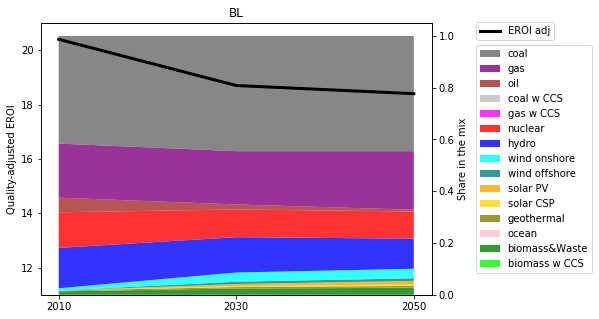

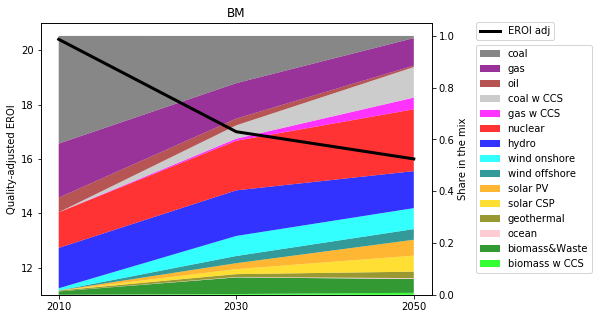

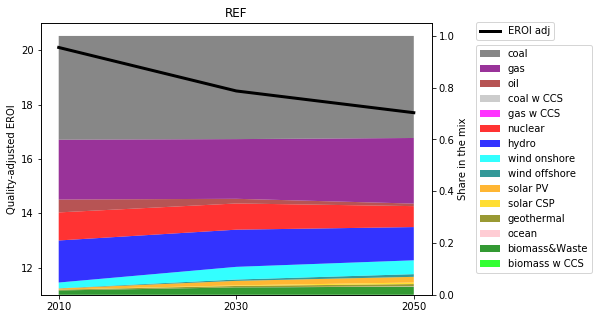

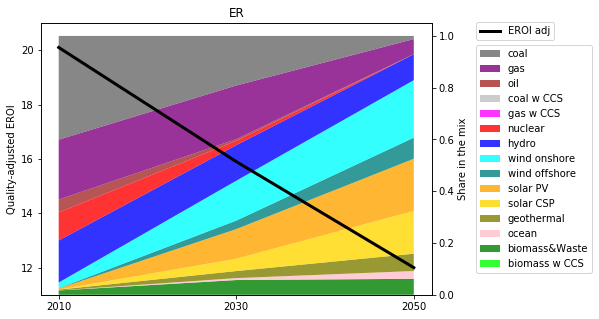

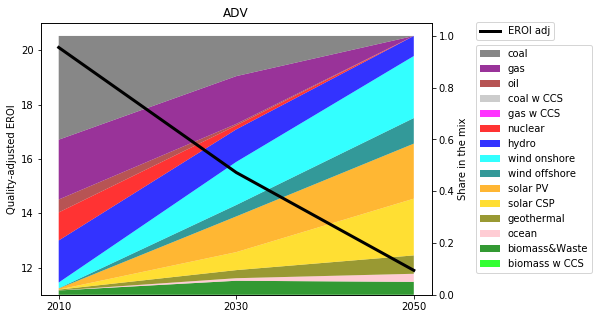

In [48]:
EROIs_mixes = results(themis, scenarios = scenarios+scenarios_dlr, stats=['eroi_adj', 'mix'], to_plot=True)
for scenario_fig in scenarios+scenarios_dlr:
    if 'total' in EROIs_mixes.index: tot_name = 'total'
    else: tot_name = 'Total (PWh/a)'
    EROIs_mixes = EROIs_mixes.loc[['biomass w CCS', 'biomass&Waste', 'ocean', 'geothermal','solar CSP','solar PV','wind offshore',\
                                   'wind onshore','hydro','nuclear', 'gas w CCS', 'coal w CCS', 'oil', 'gas', 'coal', tot_name]]
    InteractiveShell.ast_node_interactivity = 'last'
    colors = ['lime', 'green', 'pink', 'olive', 'gold', 'orange', 'teal', 'aqua', 'b', 'r', 'magenta', 'silver', 'brown', 'purple', 'dimgrey']
    fig = plt.figure(figsize=(7,5)) # 7,5
    _ = ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(years, EROIs_mixes[[(scenario_fig, year, 'EROI adj') for year in years]].loc[tot_name], \
            label='EROI adj', color='black', zorder=20, linewidth=3)
    _ = ax.set_ylabel('Quality-adjusted EROI')
    _ = ax.set_ylim([11, 21]) # 5, 10; 13, 18; 11.5, 17.5
    # ax.set_zorder(1)
    _ = ax2 = ax.twinx()
    _ = ax2.stackplot(years, EROIs_mixes.replace('–',0).fillna(0)[[(scenario_fig, year, 'mix') for year in years]].iloc[:15], \
                  labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
    _ = ax2.set_title(scenario_fig)
    _ = plt.ylabel('Share in the mix')
    _ = plt.xlabel(scenario_fig+' scenario')
    _ = xticks(years)
    _ = handles, labels = ax2.get_legend_handles_labels()
    _ = ax2.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.1,0.5)) 
    _ = ax.legend(loc='center left', bbox_to_anchor=(1.1,0.97))
    _ = ax.set_zorder(ax2.get_zorder()+1)
    _ = ax.patch.set_visible(False)
    _ = fig.savefig('Evolution of EROI adj in '+scenario_fig+'.png', dpi=200, bbox_inches="tight")

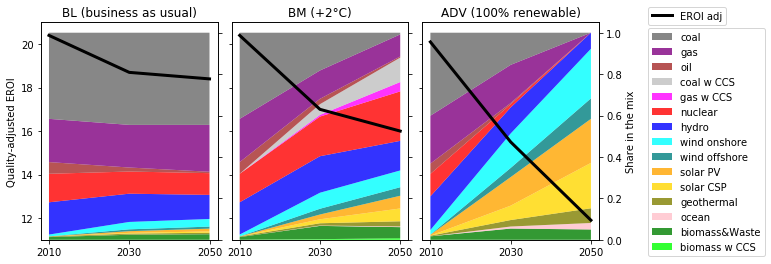

In [49]:
EROIs_mixes = results(themis, scenarios = scenarios+scenarios_dlr, stats=['eroi_adj', 'mix'], to_plot=True)
# f, axarr = plt.subplots(2, sharex=True)
# axarr[0].plot(x, y)
# axarr[0].set_title('Sharing X axis')
# axarr[1].scatter(x, y)
if 'total' in EROIs_mixes.index: tot_name = 'total'
else: tot_name = 'Total (PWh/a)'
EROIs_mixes = EROIs_mixes.loc[['biomass w CCS', 'biomass&Waste', 'ocean', 'geothermal','solar CSP','solar PV','wind offshore',\
                               'wind onshore','hydro','nuclear', 'gas w CCS', 'coal w CCS', 'oil', 'gas', 'coal', tot_name]]
InteractiveShell.ast_node_interactivity = 'last'
colors = ['lime', 'green', 'pink', 'olive', 'gold', 'orange', 'teal', 'aqua', 'b', 'r', 'magenta', 'silver', 'brown', 'purple', 'dimgrey']
fig = plt.figure(figsize=(10,4)) # 7,5
_ = ylims = [11, 21] # 5, 10; 13, 18

ax1 = fig.add_subplot(1, 3, 1)
_ = ax1.plot(years, EROIs_mixes[[('BL', year, 'EROI adj') for year in years]].loc[tot_name], \
        label='EROI adj', color='black', zorder=20, linewidth=3)
_ = ax1.set_ylabel('Quality-adjusted EROI')
_ = ax1.set_ylim(ylims)
# ax.set_zorder(1)
_ = ax12 = ax1.twinx()
_ = ax12.stackplot(years, EROIs_mixes.fillna(0)[[('BL', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax1.set_title('BL (business as usual)')
_ = xticks(years)
handles, labels = ax12.get_legend_handles_labels()
_ = ax1.set_zorder(ax12.get_zorder()+1)
_ = ax1.patch.set_visible(False)
# ax12.get_yaxis().set_visible(False)
_ = ax12.tick_params(labelright=False)

ax2 = fig.add_subplot(132)
_ = ax2.plot(years, EROIs_mixes[[('BM', year, 'EROI adj') for year in years]].loc[tot_name], \
        label='EROI adj', color='black', zorder=20, linewidth=3)
# ax2.set_ylabel('EROI')
_ = ax2.set_ylim(ylims)
# ax.set_zorder(1)
ax22 = ax2.twinx()
_ = ax22.stackplot(years, EROIs_mixes.fillna(0)[[('BM', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax2.set_title('BM (+2°C)')
_ = xticks(years)
handles, labels = ax22.get_legend_handles_labels()
_ = ax2.set_zorder(ax22.get_zorder()+1)
_ = ax2.patch.set_visible(False)
_ = ax2.tick_params(labelleft=False)
_ = ax22.tick_params(labelright=False)
# ax2.get_yaxis().set_visible(False)
# ax22.get_yaxis().set_visible(False)

ax3 = fig.add_subplot(133)
_ = ax3.plot(years, EROIs_mixes[[('ADV', year, 'EROI adj') for year in years]].loc[tot_name], \
        label='EROI adj', color='black', zorder=20, linewidth=3)
# ax3.set_ylabel('EROI')
_ = ax3.set_ylim(ylims)
# ax.set_zorder(1)
ax32 = ax3.twinx()
_ = ax32.stackplot(years, EROIs_mixes.replace('–',0).fillna(0)[[('ADV', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax3.set_title('ADV (100% renewable)') # ER (+2°C wo CCS nor nuclear)
_ = plt.ylabel('Share in the mix')
_ = xticks(years)
handles, labels = ax32.get_legend_handles_labels()
_ = ax32.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.25,0.45)) # (1.1,0.5)
_ = ax3.legend(loc='center left', bbox_to_anchor=(1.25,1.03)) # (1.1,0.97)
_ = ax3.set_zorder(ax32.get_zorder()+1)
_ = ax3.patch.set_visible(False)
# ax3.get_yaxis().set_visible(False)
_ = ax3.tick_params(labelleft=False)
_ = plt.subplots_adjust(wspace=0.08, hspace=0.08)

_ = fig.savefig('Evolution of EROIs adj IEA-ADV.png', dpi=200, bbox_inches="tight")

#### EROIs w/o GW adjustment

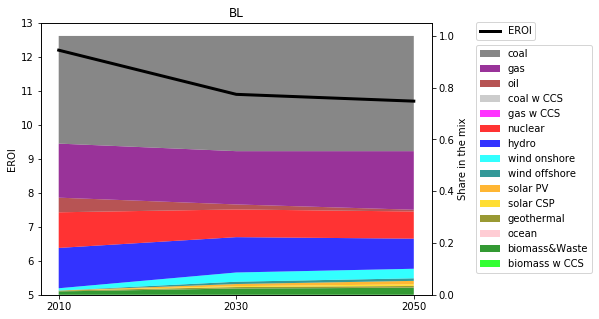

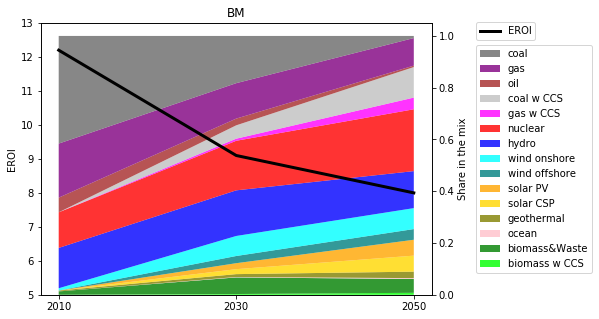

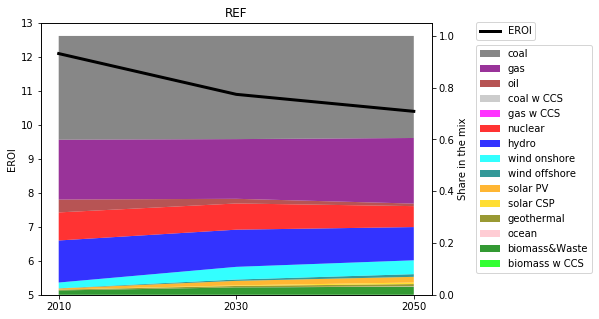

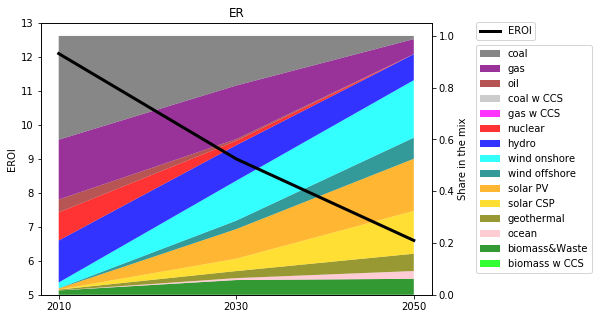

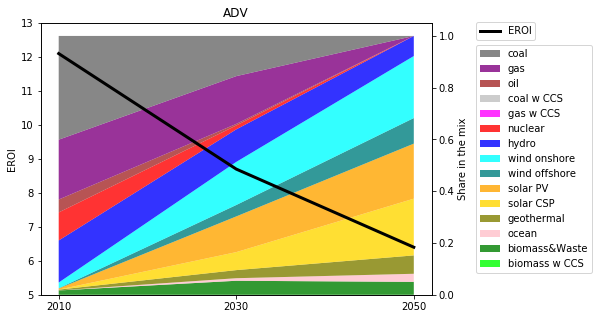

In [50]:
EROIs_mixes = results(themis, scenarios = scenarios+scenarios_dlr, stats=['EROI w/o GW', 'mix'], to_plot=True, extend_wo_GW = True)
for scenario_fig in scenarios+scenarios_dlr:
    if 'total' in EROIs_mixes.index: tot_name = 'total'
    else: tot_name = 'Total (PWh/a)'
    EROIs_mixes = EROIs_mixes.loc[['biomass w CCS', 'biomass&Waste', 'ocean', 'geothermal','solar CSP','solar PV','wind offshore',\
                                   'wind onshore','hydro','nuclear', 'gas w CCS', 'coal w CCS', 'oil', 'gas', 'coal', tot_name]]
    InteractiveShell.ast_node_interactivity = 'last'
    colors = ['lime', 'green', 'pink', 'olive', 'gold', 'orange', 'teal', 'aqua', 'b', 'r', 'magenta', 'silver', 'brown', 'purple', 'dimgrey']
    fig = plt.figure(figsize=(7,5)) # 7,5
    _ = ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(years, EROIs_mixes[[(scenario_fig, year, 'EROI w/o GW') for year in years]].loc[tot_name], \
            label='EROI', color='black', zorder=20, linewidth=3)
    _ = ax.set_ylabel('EROI')
    _ = ax.set_ylim([5, 13]) # 5, 10; 13, 18; 11.5, 17.5
    # ax.set_zorder(1)
    _ = ax2 = ax.twinx()
    _ = ax2.stackplot(years, EROIs_mixes.replace('–',0).fillna(0)[[(scenario_fig, year, 'mix') for year in years]].iloc[:15], \
                  labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
    _ = ax2.set_title(scenario_fig)
    _ = plt.ylabel('Share in the mix')
    _ = plt.xlabel(scenario_fig+' scenario')
    _ = xticks(years)
    _ = handles, labels = ax2.get_legend_handles_labels()
    _ = ax2.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.1,0.5)) 
    _ = ax.legend(loc='center left', bbox_to_anchor=(1.1,0.97))
    _ = ax.set_zorder(ax2.get_zorder()+1)
    _ = ax.patch.set_visible(False)
    _ = fig.savefig('Evolution of EROI wo GW in '+scenario_fig+'.png', dpi=200, bbox_inches="tight")

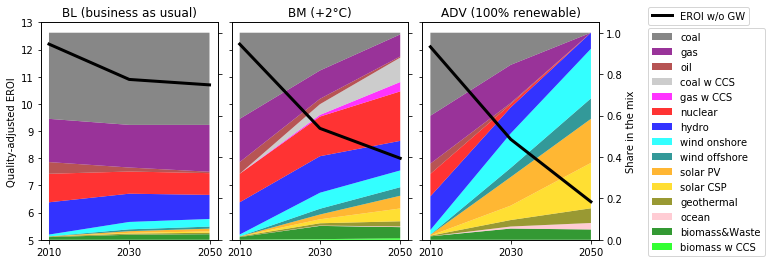

In [51]:
EROIs_mixes = results(themis, scenarios = scenarios+scenarios_dlr, stats=['EROI w/o GW', 'mix'], to_plot=True, extend_wo_GW = True)
# f, axarr = plt.subplots(2, sharex=True)
# axarr[0].plot(x, y)
# axarr[0].set_title('Sharing X axis')
# axarr[1].scatter(x, y)
if 'total' in EROIs_mixes.index: tot_name = 'total'
else: tot_name = 'Total (PWh/a)'
EROIs_mixes = EROIs_mixes.loc[['biomass w CCS', 'biomass&Waste', 'ocean', 'geothermal','solar CSP','solar PV','wind offshore',\
                               'wind onshore','hydro','nuclear', 'gas w CCS', 'coal w CCS', 'oil', 'gas', 'coal', tot_name]]
InteractiveShell.ast_node_interactivity = 'last'
colors = ['lime', 'green', 'pink', 'olive', 'gold', 'orange', 'teal', 'aqua', 'b', 'r', 'magenta', 'silver', 'brown', 'purple', 'dimgrey']
fig = plt.figure(figsize=(10,4)) # 7,5
_ = ylims = [5, 13] # 5, 10; 13, 18

ax1 = fig.add_subplot(1, 3, 1)
_ = ax1.plot(years, EROIs_mixes[[('BL', year, 'EROI w/o GW') for year in years]].loc[tot_name], \
        label='EROI w/o GW', color='black', zorder=20, linewidth=3)
_ = ax1.set_ylabel('Quality-adjusted EROI')
_ = ax1.set_ylim(ylims)
# ax.set_zorder(1)
_ = ax12 = ax1.twinx()
_ = ax12.stackplot(years, EROIs_mixes.fillna(0)[[('BL', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax1.set_title('BL (business as usual)')
_ = xticks(years)
handles, labels = ax12.get_legend_handles_labels()
_ = ax1.set_zorder(ax12.get_zorder()+1)
_ = ax1.patch.set_visible(False)
# ax12.get_yaxis().set_visible(False)
_ = ax12.tick_params(labelright=False)

ax2 = fig.add_subplot(132)
_ = ax2.plot(years, EROIs_mixes[[('BM', year, 'EROI w/o GW') for year in years]].loc[tot_name], \
        label='EROI w/o GW', color='black', zorder=20, linewidth=3)
# ax2.set_ylabel('EROI')
_ = ax2.set_ylim(ylims)
# ax.set_zorder(1)
ax22 = ax2.twinx()
_ = ax22.stackplot(years, EROIs_mixes.fillna(0)[[('BM', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax2.set_title('BM (+2°C)')
_ = xticks(years)
handles, labels = ax22.get_legend_handles_labels()
_ = ax2.set_zorder(ax22.get_zorder()+1)
_ = ax2.patch.set_visible(False)
_ = ax2.tick_params(labelleft=False)
_ = ax22.tick_params(labelright=False)
# ax2.get_yaxis().set_visible(False)
# ax22.get_yaxis().set_visible(False)

ax3 = fig.add_subplot(133)
_ = ax3.plot(years, EROIs_mixes[[('ADV', year, 'EROI w/o GW') for year in years]].loc[tot_name], \
        label='EROI w/o GW', color='black', zorder=20, linewidth=3)
# ax3.set_ylabel('EROI')
_ = ax3.set_ylim(ylims)
# ax.set_zorder(1)
ax32 = ax3.twinx()
_ = ax32.stackplot(years, EROIs_mixes.replace('–',0).fillna(0)[[('ADV', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax3.set_title('ADV (100% renewable)') # ER (+2°C wo CCS nor nuclear)
_ = plt.ylabel('Share in the mix')
_ = xticks(years)
handles, labels = ax32.get_legend_handles_labels()
_ = ax32.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.25,0.45)) # (1.1,0.5)
_ = ax3.legend(loc='center left', bbox_to_anchor=(1.25,1.03)) # (1.1,0.97)
_ = ax3.set_zorder(ax32.get_zorder()+1)
_ = ax3.patch.set_visible(False)
# ax3.get_yaxis().set_visible(False)
_ = ax3.tick_params(labelleft=False)
_ = plt.subplots_adjust(wspace=0.08, hspace=0.08)

_ = fig.savefig('Evolution of EROIs wo GW IEA-ADV.png', dpi=200, bbox_inches="tight")

#### Quality-adjusted EROIs w/o GW adjustment

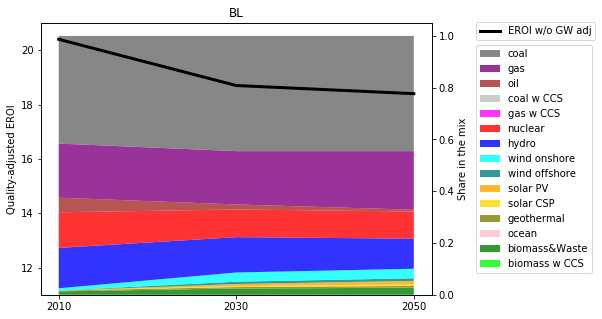

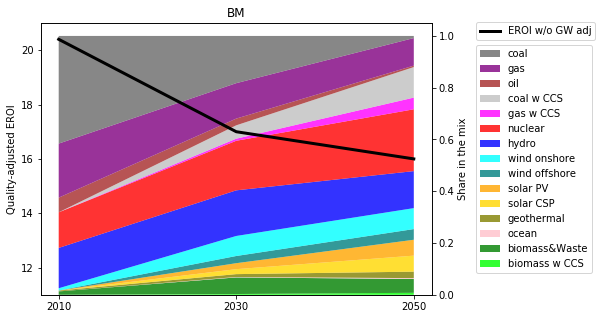

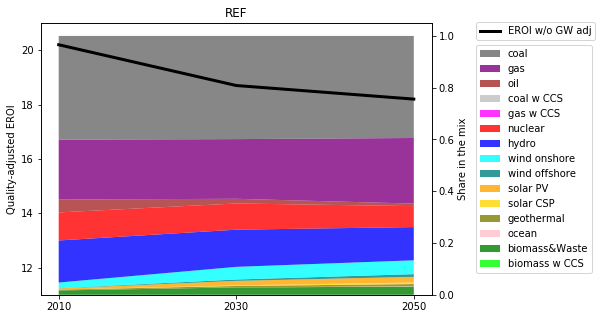

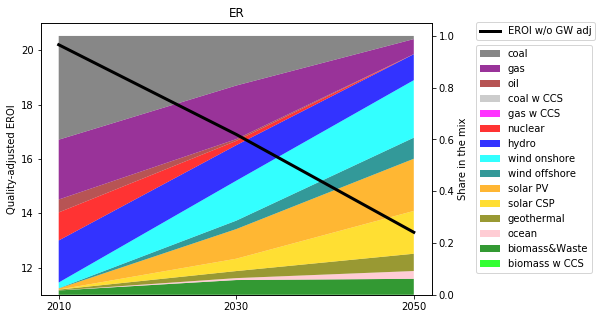

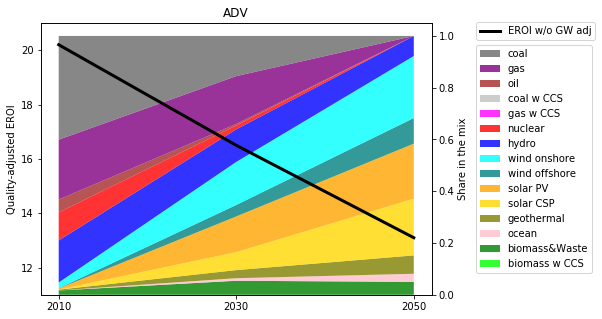

In [52]:
EROIs_mixes = results(themis, scenarios = scenarios+scenarios_dlr, stats=['EROI w/o GW adj', 'mix'], to_plot=True, extend_wo_GW = True)
for scenario_fig in scenarios+scenarios_dlr:
    if 'total' in EROIs_mixes.index: tot_name = 'total'
    else: tot_name = 'Total (PWh/a)'
    EROIs_mixes = EROIs_mixes.loc[['biomass w CCS', 'biomass&Waste', 'ocean', 'geothermal','solar CSP','solar PV','wind offshore',\
                                   'wind onshore','hydro','nuclear', 'gas w CCS', 'coal w CCS', 'oil', 'gas', 'coal', tot_name]]
    InteractiveShell.ast_node_interactivity = 'last'
    colors = ['lime', 'green', 'pink', 'olive', 'gold', 'orange', 'teal', 'aqua', 'b', 'r', 'magenta', 'silver', 'brown', 'purple', 'dimgrey']
    fig = plt.figure(figsize=(7,5)) # 7,5
    _ = ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(years, EROIs_mixes[[(scenario_fig, year, 'EROI w/o GW adj') for year in years]].loc[tot_name], \
            label='EROI w/o GW adj', color='black', zorder=20, linewidth=3)
    _ = ax.set_ylabel('Quality-adjusted EROI')
    _ = ax.set_ylim([11, 21]) # 5, 10; 13, 18; 11.5, 17.5
    # ax.set_zorder(1)
    _ = ax2 = ax.twinx()
    _ = ax2.stackplot(years, EROIs_mixes.replace('–',0).fillna(0)[[(scenario_fig, year, 'mix') for year in years]].iloc[:15], \
                  labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
    _ = ax2.set_title(scenario_fig)
    _ = plt.ylabel('Share in the mix')
    _ = plt.xlabel(scenario_fig+' scenario')
    _ = xticks(years)
    _ = handles, labels = ax2.get_legend_handles_labels()
    _ = ax2.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.1,0.5)) 
    _ = ax.legend(loc='center left', bbox_to_anchor=(1.1,0.97))
    _ = ax.set_zorder(ax2.get_zorder()+1)
    _ = ax.patch.set_visible(False)
    _ = fig.savefig('Evolution of EROI adj wo GW in '+scenario_fig+'.png', dpi=200, bbox_inches="tight")

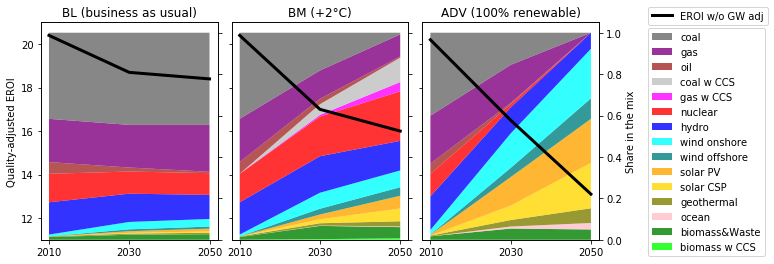

In [53]:
EROIs_mixes = results(themis, scenarios = scenarios+scenarios_dlr, stats=['EROI w/o GW adj', 'mix'], to_plot=True, extend_wo_GW = True)
# f, axarr = plt.subplots(2, sharex=True)
# axarr[0].plot(x, y)
# axarr[0].set_title('Sharing X axis')
# axarr[1].scatter(x, y)
if 'total' in EROIs_mixes.index: tot_name = 'total'
else: tot_name = 'Total (PWh/a)'
EROIs_mixes = EROIs_mixes.loc[['biomass w CCS', 'biomass&Waste', 'ocean', 'geothermal','solar CSP','solar PV','wind offshore',\
                               'wind onshore','hydro','nuclear', 'gas w CCS', 'coal w CCS', 'oil', 'gas', 'coal', tot_name]]
InteractiveShell.ast_node_interactivity = 'last'
colors = ['lime', 'green', 'pink', 'olive', 'gold', 'orange', 'teal', 'aqua', 'b', 'r', 'magenta', 'silver', 'brown', 'purple', 'dimgrey']
fig = plt.figure(figsize=(10,4)) # 7,5
_ = ylims = [11, 21] # 5, 10; 13, 18

ax1 = fig.add_subplot(1, 3, 1)
_ = ax1.plot(years, EROIs_mixes[[('BL', year, 'EROI w/o GW adj') for year in years]].loc[tot_name], \
        label='EROI w/o GW adj', color='black', zorder=20, linewidth=3)
_ = ax1.set_ylabel('Quality-adjusted EROI')
_ = ax1.set_ylim(ylims)
# ax.set_zorder(1)
_ = ax12 = ax1.twinx()
_ = ax12.stackplot(years, EROIs_mixes.fillna(0)[[('BL', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax1.set_title('BL (business as usual)')
_ = xticks(years)
handles, labels = ax12.get_legend_handles_labels()
_ = ax1.set_zorder(ax12.get_zorder()+1)
_ = ax1.patch.set_visible(False)
# ax12.get_yaxis().set_visible(False)
_ = ax12.tick_params(labelright=False)

ax2 = fig.add_subplot(132)
_ = ax2.plot(years, EROIs_mixes[[('BM', year, 'EROI w/o GW adj') for year in years]].loc[tot_name], \
        label='EROI w/o GW adj', color='black', zorder=20, linewidth=3)
# ax2.set_ylabel('EROI')
_ = ax2.set_ylim(ylims)
# ax.set_zorder(1)
ax22 = ax2.twinx()
_ = ax22.stackplot(years, EROIs_mixes.fillna(0)[[('BM', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax2.set_title('BM (+2°C)')
_ = xticks(years)
handles, labels = ax22.get_legend_handles_labels()
_ = ax2.set_zorder(ax22.get_zorder()+1)
_ = ax2.patch.set_visible(False)
_ = ax2.tick_params(labelleft=False)
_ = ax22.tick_params(labelright=False)
# ax2.get_yaxis().set_visible(False)
# ax22.get_yaxis().set_visible(False)

ax3 = fig.add_subplot(133)
_ = ax3.plot(years, EROIs_mixes[[('ADV', year, 'EROI w/o GW adj') for year in years]].loc[tot_name], \
        label='EROI w/o GW adj', color='black', zorder=20, linewidth=3)
# ax3.set_ylabel('EROI')
_ = ax3.set_ylim(ylims)
# ax.set_zorder(1)
ax32 = ax3.twinx()
_ = ax32.stackplot(years, EROIs_mixes.replace('–',0).fillna(0)[[('ADV', year, 'mix') for year in years]].iloc[:15], \
              labels=EROIs_mixes.index[:15], colors=colors, alpha = 0.8, zorder=1)
_ = ax3.set_title('ADV (100% renewable)') # ER (+2°C wo CCS nor nuclear)
_ = plt.ylabel('Share in the mix')
_ = xticks(years)
handles, labels = ax32.get_legend_handles_labels()
_ = ax32.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.25,0.45)) # (1.1,0.5)
_ = ax3.legend(loc='center left', bbox_to_anchor=(1.25,1.03)) # (1.1,0.97)
_ = ax3.set_zorder(ax32.get_zorder()+1)
_ = ax3.patch.set_visible(False)
# ax3.get_yaxis().set_visible(False)
_ = ax3.tick_params(labelleft=False)
_ = plt.subplots_adjust(wspace=0.08, hspace=0.08)

_ = fig.savefig('Evolution of EROIs adj wo GW IEA-ADV.png', dpi=200, bbox_inches="tight")